In [2]:
import torch
import numpy as np
from dataclasses import dataclass, field
from typing import List, Tuple
import matplotlib.pyplot as plt

@dataclass
class Configs:
    
    #...general params:
    workdir : str = '../../results/gauss_test/'   
    device : str = 'cuda:0'
    multi_gpu : bool = False

    #...data params:
    target : str = 'Ngaussians'
    source : str = 'StdGauss'
    num_points : int = 51200
    dim_continuous : int = 2
    dim_discrete : int = 0
    dim_context : int = 0
    num_gaussians : int = 8
    vocab_size : int = 0

    #...model params:
    model : str = 'mlp'
    num_layers : int = 4
    dim_hidden : int = 64 
    dim_continuous_emb : int = 0
    dim_time_emb : int = 16
    time_embedding  : str = 'kolmogorov-arnold'    
    dropout : float = 0.0
    activation : str = 'SELU'
    use_batch_norm : bool = False
    
    #...training params:
    batch_size : int = 256
    data_split_frac : List[float] = field(default_factory = lambda : [1.0, 0.0, 0.0])  # train / val / test 
    epochs: int = 100
    early_stopping : int = None
    min_epochs : int = None 
    print_epochs : int = None   
    num_workers : int = 0
    pin_memory: bool = False

    #...cfm params:
    dynamics : str = 'CFM'
    sigma: float = 0.1

    #...optimization & scheduler params:
    optimizer: str = 'Adam'
    lr : float = 2e-4
    weight_decay : float = 0.0
    optimizer_betas : List[float] = field(default_factory = lambda : [0.9, 0.999])
    optimizer_eps : float = 1e-8
    optimizer_amsgrad : bool = False
    gradient_clip : float = None
    scheduler: str = None
    scheduler_t_max: int = None
    scheduler_eta_min: float = None
    scheduler_gamma: float = None
    scheduler_step_size: int = None

    #...generation pipeline params:
    sampler : str = 'EulerSolver'
    solver = 'euler'
    num_timesteps : int = 1000
    time_eps : float = 0

    def __post_init__(self):

        self.data = self.source + '_to_' + self.target

        if self.dim_discrete: 
            assert self.dim_discrete == 1
            self.dim_context = 0
            self.dim_context_emb = 0 
            self.num_colors = self.vocab_size
        else:
            self.dim_discrete_emb = 0
            self.num_colors = 1

        if self.dim_context:  
            assert self.dim_context == 1
            self.dim_discrete = 0
            self.dim_discretet_emb = 0 
            self.num_colors = self.vocab_size
        else:
            self.dim_context_emb = 0
            self.num_colors = 1

        if self.multi_gpu: self.device = 'cuda:0'



## CFM: 8-gaussians $\to$ 2-moons

/home/df630/CMB/src/cmb/data/toys.py:141: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(self.continuous[:num_points, 0], self.continuous[:num_points, 1], c=c, **kwargs)
/home/df630/CMB/src/cmb/data/toys.py:112: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(self.continuous[:num_points, 0], self.continuous[:num_points, 1], c=c, **kwargs)


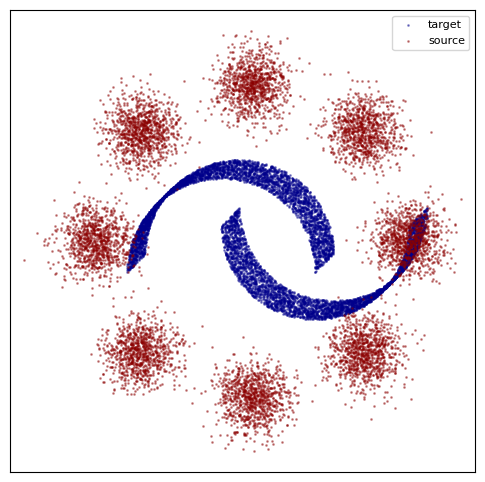

In [3]:
from cmb.data.toys import CouplingData

config = Configs(source='Ngaussians',
                 target='TwoMoons',
                 num_points=51200,
                 dim_continuous=2,
                 dim_discrete=0,
                 dim_context=0,
                 num_gaussians=8,
                 vocab_size=0)

toys = CouplingData(config=config)

_, ax = plt.subplots(1, 1, figsize=(6, 6)) 
toys.target.display(num_points=8000, s=1, ax=ax, cmap='tab10', alpha=0.4, color='darkblue', label='target')
toys.source.display(num_points=8000, s=1, ax=ax, cmap='tab10', alpha=0.4, color='darkred', label='source')
plt.legend(fontsize=8)
plt.show()

In [3]:
from cmb.dynamics.cfm import ConditionalFlowMatching
from cmb.models.trainers import CMBTrainer
from cmb.models.architectures.deep_nets import MLP

config.batch_size=256
config.num_layers=4
config.dim_hidden=64 
config.dim_time_emb=16
config.dropout=0.0
config.activation='SELU'
config.use_batch_norm=False

dynamics = ConditionalFlowMatching(config)
mlp = MLP(config)
generative_model = CMBTrainer(dynamics, mlp, toys)
generative_model.train()


2024-09-12 17:24:00.271705: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-09-12 17:24:00.315783: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-09-12 17:24:00.316441: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-12 17:24:01.066037: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
number of training parameters: 9826
start training...


INFO: building dataloaders...
INFO: train/val/test split ratios: 1.0/0.0/0.0
INFO: train size: 51200, validation size: 0, testing sizes: 0


epochs:   0%|          | 0/100 [00:00<?, ?it/s]

In [7]:
import torch
from dataclasses import dataclass
import torchdyn
from torchdyn.core import NeuralODE

class CFMPipeline:
    
    def __init__(self, 
                 trained_model, 
                 config: dataclass=None,
                 best_epoch_model: bool=False,
                 ):

        self.config = config
        self.trained_model = trained_model
        self.model = self.trained_model.best_epoch_model if best_epoch_model else self.trained_model.last_epoch_model
        self.num_sampling_steps = config.num_timesteps
        self.sampler = config.sampler
        self.device = config.device
        self.has_context = False
        self.time_steps = torch.linspace(0.0, 1.0, config.num_timesteps, device=self.device)

    def generate_samples(self, source, context=None, mask=None):
        self.source = source.to(self.device)
        self.context = context.to(self.device) if context is not None else None
        self.mask = mask.to(self.device) if mask is not None else None
        self.trajectories = self.ODEsolver() 

    @torch.no_grad()
    def ODEsolver(self):

        print('INFO: {} with {} method and steps={}'.format(self.sampler, self.config.solver, self.config.num_timesteps))

        drift = ContextWrapper(self.model, context=self.context, mask=self.mask) 

        if self.sampler == 'EulerSolver':
            node = EulerSolver(vector_field=drift, device=self.device)

        # else:
        #     node = NeuralODE(drift, solver="dopri5", sensitivity="adjoint", atol=1e-4, rtol=1e-4)
        
        trajectories = node.trajectory(x=self.source, t_span=self.time_steps).detach().cpu()

        return trajectories

class ContextWrapper(torch.nn.Module):
    """ Wraps model to torchdyn compatible format.
    """
    def __init__(self, net, context=None, mask=None):
        super().__init__()
        self.nn = net
        self.context = context
        self.mask = mask
    def forward(self, t, x, k=None):
        if x is not None: 
            t = t.repeat(x.shape[0])
            t = self.reshape_time_like(t, x)
        else: 
            t = t.repeat(k.shape[0])
            t = self.reshape_time_like(t, k)
        return self.nn(t=t, x=x, k=k, context=self.context, mask=self.mask)

    def reshape_time_like(self, t, tensor):
        if isinstance(t, (float, int)): return t
        else: return t.reshape(-1, *([1] * (tensor.dim() - 1)))


class EulerSolver:
    def __init__(self, vector_field, device):
        self.vector_field = vector_field
        self.device = device

    def trajectory(self, t_span, x, k=None):
        time_steps = len(t_span)
        dt = (t_span[-1] - t_span[0]) / (time_steps - 1)
        trajectory = [x]

        for i in range(1, time_steps):
            t = t_span[i-1]
            x = x + dt * self.vector_field(t, x=x, k=k).to(self.device)
            trajectory.append(x)

        return torch.stack(trajectory)


In [8]:
config = Configs(target='TwoMoons', 
                 source='Ngaussians', 
                 num_points=1000, 
                 num_gaussians=8
                 )

input = DataCoupling(config=config)


In [9]:
pipeline = CFMPipeline(trained_model=generative_model, config=config)
with torch.no_grad():
    pipeline.generate_samples(input.source.continuous)



INFO: EulerSolver with euler method and steps=1000


TypeError: cannot unpack non-iterable ContextWrapper object

/tmp/ipykernel_430258/404298159.py:5: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(traj[i, :N, 0], traj[i, :N, 1], s=.01, alpha=.05, c='k', cmap = 'tab10')
/tmp/ipykernel_430258/404298159.py:6: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(traj[0, :N, 0], traj[0, :N, 1], s=1, alpha=1, c= 'b', cmap = 'tab10', label='t=0')
/tmp/ipykernel_430258/404298159.py:7: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(traj[-1, :N, 0], traj[-1, :N, 1], s=1, alpha=1, c= 'r', cmap = 'tab10', label='t=1')


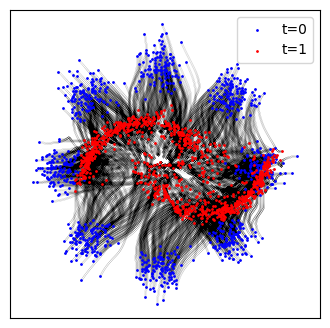

In [33]:
def plot_trajectories(config, traj,  N=100000):
    """Plot trajectories of some selected samples."""
    plt.figure(figsize=(4, 4))
    for i in range(traj.shape[0]): 
        plt.scatter(traj[i, :N, 0], traj[i, :N, 1], s=.01, alpha=.05, c='k', cmap = 'tab10')
    plt.scatter(traj[0, :N, 0], traj[0, :N, 1], s=1, alpha=1, c= 'b', cmap = 'tab10', label='t=0')
    plt.scatter(traj[-1, :N, 0], traj[-1, :N, 1], s=1, alpha=1, c= 'r', cmap = 'tab10', label='t=1')
    plt.xticks([])
    plt.yticks([])
    plt.axis('equal')
    plt.legend()
    plt.show()

plot_trajectories(config, pipeline.trajectories)

/tmp/ipykernel_422998/404298159.py:5: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(traj[i, :N, 0], traj[i, :N, 1], s=.01, alpha=.05, c='k', cmap = 'tab10')
/tmp/ipykernel_422998/404298159.py:6: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(traj[0, :N, 0], traj[0, :N, 1], s=1, alpha=1, c= 'b', cmap = 'tab10', label='t=0')
/tmp/ipykernel_422998/404298159.py:7: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(traj[-1, :N, 0], traj[-1, :N, 1], s=1, alpha=1, c= 'r', cmap = 'tab10', label='t=1')
/home/df630/.conda/envs/flow_match_env/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


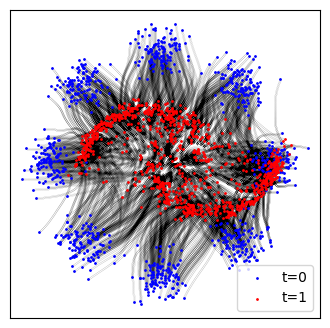

In [7]:
def plot_trajectories(config, traj,  N=100000):
    """Plot trajectories of some selected samples."""
    plt.figure(figsize=(4, 4))
    for i in range(traj.shape[0]): 
        plt.scatter(traj[i, :N, 0], traj[i, :N, 1], s=.01, alpha=.05, c='k', cmap = 'tab10')
    plt.scatter(traj[0, :N, 0], traj[0, :N, 1], s=1, alpha=1, c= 'b', cmap = 'tab10', label='t=0')
    plt.scatter(traj[-1, :N, 0], traj[-1, :N, 1], s=1, alpha=1, c= 'r', cmap = 'tab10', label='t=1')
    plt.xticks([])
    plt.yticks([])
    plt.axis('equal')
    plt.legend()
    plt.show()

plot_trajectories(config, pipeline.trajectories)

##  Conditional CFM: 8-gaussians $\to$ 2-moons with 2 colors

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


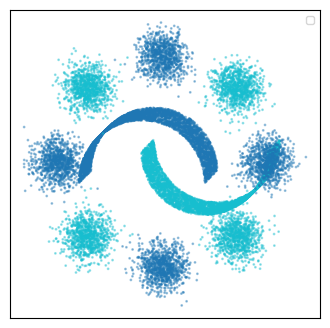

In [2]:
from cmb.data.toys import DataCoupling

config = Configs(source='Ngaussians',
                 target='TwoMoons',
                 num_points=51200,
                 dim_continuous=2,
                 dim_context=1,
                 num_gaussians=8,
                 dim_continuous_emb=16,
                 vocab_size=2)

toys = DataCoupling(config=config)

_, ax = plt.subplots(1, 1, figsize=(4, 4)) 
toys.target.display(num_points=8000, s=1, ax=ax, cmap='tab10', alpha=0.4)
toys.source.display(num_points=8000, s=1, ax=ax, cmap='tab10', alpha=0.4)
plt.legend(fontsize=8)
plt.show()

In [3]:
from cmb.dynamics.cfm import ConditionalFlowMatching
from cmb.models.trainers import CMBTrainer
from cmb.models.architectures.deep_nets import MLP

config.batch_size=256
config.num_layers=4
config.dim_hidden=64 
config.dim_time_emb=16
config.context_embedding='embedding'
config.dim_context_emb=16
config.dropout=0.0
config.activation='SELU'
config.use_batch_norm=False

dynamics = ConditionalFlowMatching(config)
mlp = MLP(config)
generative_model = CMBTrainer(dynamics, mlp, toys)
generative_model.train()

2024-09-12 16:27:56.061639: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-09-12 16:27:56.105182: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-09-12 16:27:56.105881: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-12 16:27:56.763422: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
number of training parameters: 10722
start training...


INFO: building dataloaders...
INFO: train/val/test split ratios: 1.0/0.0/0.0
INFO: train size: 51200, validation size: 0, testing sizes: 0


epochs:   0%|          | 0/100 [00:00<?, ?it/s]

In [16]:
config = Configs(target='TwoMoons', 
                 source='Ngaussians', 
                 num_points=1000, 
                 dim_continuous=2,
                 dim_context=1,
                 num_gaussians=8,
                 vocab_size=2)

input = DataCoupling(config=config)




INFO: EulerSolver with euler method and steps=1000


/tmp/ipykernel_430258/3849257965.py:10: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(traj[i, :N, 0], traj[i, :N, 1], s=.01, alpha=.05, c='k', cmap = 'tab10')
/tmp/ipykernel_430258/3849257965.py:11: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(traj[0, :N, 0], traj[0, :N, 1], s=1, alpha=1, c= 'b', cmap = 'tab10', label='t=0')
/tmp/ipykernel_430258/3849257965.py:12: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(traj[-1, :N, 0], traj[-1, :N, 1], s=1, alpha=1, c= 'r', cmap = 'tab10', label='t=1')


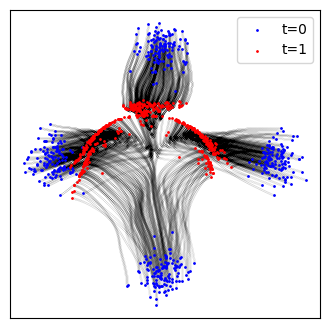

In [22]:
pipeline = CFMPipeline(trained_model=generative_model, config=config)
with torch.no_grad():
    pipeline.generate_samples(source=input.source.continuous[input.source.context == 0],
                              context=input.source.context[input.source.context == 0])
    
def plot_trajectories(config, traj,  N=100000):
    """Plot trajectories of some selected samples."""
    plt.figure(figsize=(4, 4))
    for i in range(traj.shape[0]): 
        plt.scatter(traj[i, :N, 0], traj[i, :N, 1], s=.01, alpha=.05, c='k', cmap = 'tab10')
    plt.scatter(traj[0, :N, 0], traj[0, :N, 1], s=1, alpha=1, c= 'b', cmap = 'tab10', label='t=0')
    plt.scatter(traj[-1, :N, 0], traj[-1, :N, 1], s=1, alpha=1, c= 'r', cmap = 'tab10', label='t=1')
    plt.xticks([])
    plt.yticks([])
    plt.axis('equal')
    plt.legend()
    plt.show()

plot_trajectories(config, pipeline.trajectories)

INFO: EulerSolver with euler method and steps=1000


/tmp/ipykernel_430258/3958506591.py:10: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(traj[i, :N, 0], traj[i, :N, 1], s=.01, alpha=.05, c='k', cmap = 'tab10')
/tmp/ipykernel_430258/3958506591.py:11: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(traj[0, :N, 0], traj[0, :N, 1], s=1, alpha=1, c= 'b', cmap = 'tab10', label='t=0')
/tmp/ipykernel_430258/3958506591.py:12: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(traj[-1, :N, 0], traj[-1, :N, 1], s=1, alpha=1, c= 'r', cmap = 'tab10', label='t=1')


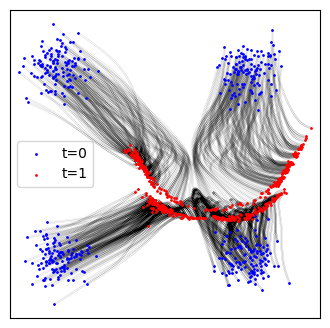

In [21]:
pipeline = CFMPipeline(trained_model=generative_model, config=config)
with torch.no_grad():
    pipeline.generate_samples(source=input.source.continuous[input.source.context == 1],
                              context=input.source.context[input.source.context == 1])
    
def plot_trajectories(config, traj,  N=100000):
    """Plot trajectories of some selected samples."""
    plt.figure(figsize=(4, 4))
    for i in range(traj.shape[0]): 
        plt.scatter(traj[i, :N, 0], traj[i, :N, 1], s=.01, alpha=.05, c='k', cmap = 'tab10')
    plt.scatter(traj[0, :N, 0], traj[0, :N, 1], s=1, alpha=1, c= 'b', cmap = 'tab10', label='t=0')
    plt.scatter(traj[-1, :N, 0], traj[-1, :N, 1], s=1, alpha=1, c= 'r', cmap = 'tab10', label='t=1')
    plt.xticks([])
    plt.yticks([])
    plt.axis('equal')
    plt.legend()
    plt.show()

plot_trajectories(config, pipeline.trajectories)